### Import libraries

In [60]:
from datetime import datetime
import keras
from keras import backend as K
from keras.layers import Concatenate, Lambda, LSTM, Reshape, Dense, Embedding, Average, Reshape, Flatten, Input, Add
from keras.models import Model 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import zipfile

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from typing import List, Callable, Dict
from nltk.stem import WordNetLemmatizer

### Download dataset
Downloading the dataset using the function provided in the assignment

In [2]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

# Uncomment if you need to dowload the dataset
#download_data('dataset')

### Preprocessing data

The next cells are devoted to perform preprocessing of the raw data into a readable format. This is done in two steps. The first step organises the data from the csv file into usable columns. More in particular, the Evidence column is cleaned and the Labels are turned into numeric values by the `firstCleaning(df)` function. In the second step, more specific cleaning is done on the Evidence and Claim column. All words are put in lowercase, special characters are replaced, uncommon symbols are filtered out, stopwords are removed and the text is stripped. Finally, lemmatization has been executed. 

#### Create dataframes

In [3]:
def firstCleaning(df): 
    """
    This method is to restructure the columns from dataframe df into a suitable format.  
    """
    df["Evidence"] = df["Evidence"].str.split(pat = "\t")
    df["evidenceID"]=df["Evidence"].str[0]
    df["Evidence"]=df["Evidence"].str[1]
    df["Label"] = df["Label"].replace({'SUPPORTS': 1, 'REFUTES': 0})
    return df

In [4]:
#create a dataframe for the training data 
train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
train_df = firstCleaning(train_df)

#create a dataframe for the validation data 
val_df = pd.read_csv('./dataset/val_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
val_df = firstCleaning(val_df)

#create a dataframe for the test data 
test_df = pd.read_csv('./dataset/test_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
test_df = firstCleaning(test_df)

#### Clean text data

In [5]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()    

def lemmatize_words(text: str ) -> str:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          lemmatize_words
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)


# Replace each sentence with its pre-processed version
train_df['Evidence'] = train_df['Evidence'].apply(lambda txt: text_prepare(txt))
val_df['Evidence'] = val_df['Evidence'].apply(lambda txt: text_prepare(txt))
test_df['Evidence'] = test_df['Evidence'].apply(lambda txt: text_prepare(txt))
train_df['Claim'] = train_df['Claim'].apply(lambda txt: text_prepare(txt))
val_df['Claim'] = val_df['Claim'].apply(lambda txt: text_prepare(txt))
test_df['Claim'] = test_df['Claim'].apply(lambda txt: text_prepare(txt))



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/solveig.mohr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Extract y values for train, val and test

In [6]:
y_train = np.array(train_df['Label'])
y_val = np.array(val_df['Label'])
y_test = np.array(test_df['Label'])

### Tokenize and padding of data

In [7]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["Claim"])
tokenizer.fit_on_texts(train_df["Evidence"])

In [8]:
# Find max sentence lenght for evidence
MAX_SEQ_LEN = np.max([len(text.split()) for text in train_df["Evidence"]])

In [9]:
def textToTensor(tokenizer, max_len, text):
    '''
        Converts text to tensors by converting the words into the correct indexes. 
        Then padds the tensors with 0 vlaues
    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len)
    return padded

In [10]:
claim_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Claim"])
evidence_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Evidence"])

claim_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Claim"])
evidence_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Evidence"])

claim_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Claim"])
evidence_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Evidence"])

In [11]:
# Find size of vocabulary
VOCABULARY_SIZE = len(tokenizer.word_index) + 1

## Applying glove 


In [12]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model
    
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix



In [13]:
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_dimension)
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)
embedding_matrix.shape

(32234, 50)

### Create model

- Choose type of sentence embedding by passing the sentence embedding number (1,2,3 or 4) to the create_model function.
- Choose type of merging by passing the merge number (1,2 or 3) to the create_model function.

In [69]:
def create_model(max_tokens, vocab_size, embedding_dimension, sentence_embedding_type=1, merge_type=1):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimension of the embedding vectors
            sentence_embedding_type (int): Defines which sentence embedding to use
            merge_type (int): Defines which merging function to use
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    claims_input = Input(shape=(max_tokens, ))
    evidence_input = Input(shape=(max_tokens, ))
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Word embedding ------------------------------------------------------------
    claims_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_claims', trainable = False)(claims_input)
    evidence_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_evidence', trainable = False)(evidence_input)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Sentence embedding -------------------------------------------------------
    if sentence_embedding_type==1:
        # Encode token sequences via a RNN and take the last state as the sentence embedding.
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_evidence')(evidence_embedding)
    elif sentence_embedding_type==2:
        # Encode token sequences via a RNN and average all the output states.

        # Put return_sequences True to get output from all hidden states
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence')(evidence_embedding)
        
        # Take average of outputs
        claims_sentence_embedding = K.mean(claims_sentence_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_sentence_embedding, axis=1)

    elif sentence_embedding_type==3:
        # Encode token sequences via a simple MLP layer.
        num = embedding_dimension*max_tokens
        # Reshape 3d vector to 2d
        claims_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(claims_embedding)
        evidence_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(evidence_embedding)

        # Send into dense layer
        claims_sentence_embedding = Dense(num, name='SentenceEmbedding_claims')(claims_sentence_embedding)
        evidence_sentence_embedding = Dense(num, name='SentenceEmbedding_evidence')(evidence_sentence_embedding)
   
    elif sentence_embedding_type==4:
        # Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
        claims_sentence_embedding = K.mean(claims_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_embedding, axis=1)
    else:
        raise Exception("Sentence embedding type must be an integer between 1 and 4")
    #------------------------------------------------------------------------------------------------------------
    

    #-------------------------- Extension with cosine similarity -----------------------------------------------
    # Calulate cosine similarity
    # Returns list of cosine similarities for each evidence claim pair
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
    cosine_similarity = cosine_loss(claims_sentence_embedding, evidence_sentence_embedding)

    # Expand dimention to get tensor on shape (embedding_dimension, 1)
    cosine_similarity = Lambda(lambda x: K.expand_dims(x, axis=1))(cosine_similarity)

    # Concatenate tensors and get them on shape (batch_size, embedding_dim + 1)
    claims_sentence_embedding = Concatenate(axis=-1)([claims_sentence_embedding, cosine_similarity])
    evidence_sentence_embedding = Concatenate(axis=-1)([evidence_sentence_embedding, cosine_similarity])
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Merging --------------------------------------------------------------
    if merge_type == 1:
        # Concatenate
        merged = Concatenate(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 2:
        # Sum
        merged = Add()([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 3:
        # Mean
        merged = Average()([claims_sentence_embedding, evidence_sentence_embedding])
    else:
        raise Exception("Merge type must be an integer between 1 and 3")
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Classification --------------------------------------------------------------
    out = (Dense(1, activation='sigmoid'))(merged)
    #------------------------------------------------------------------------------------------------------------

    model = Model(inputs=[claims_input, evidence_input], outputs=[out])

    return model

### Funcitons for saving, predicting, plotting and evaluating the models


#### Save model

In [47]:
def save_model(model, sentence_embedding_type=1, merge_type=1, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_SE{sentence_embedding_type}_MT{merge_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)

#### Get predicitons

In [ ]:
def prediction(model: keras.Model, x, predicting_info):
    '''Call the models prediction function'''
    predictions = model.predict(x, **predicting_info)
    return predictions

#### Plot accuracy and loss

In [48]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

#### Fucniton for multi-input classification evaluation

In [49]:
def evaluation(predictions):
    '''
        Function for plotting the confusion_matrix
        Inputs:
            predicitons: Predicitons from a keras model
    '''
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cf_matrix)

#### Funcitons for claim verification evaluation

In [50]:
def make_claims_dict():
    """
    Makes a dictionary with claimID as key and 
    a list of the index for every evidence 
    corresponding to the claim as value
    """
    claims = {}
    t = test_df.groupby("claimID")
    for name, group in t:
        claims[name] = list(group.index)
    return claims

In [51]:
def majority_pred(predictions):
    """
    Find predictions based on majority voting
    """
    majority = []

    for i in range(len(claim_test)):
        claim_id = np.array(test_df['claimID'])[i]
        support = 0
        defutes = 0
        for evidence in claims_dict[claim_id]:
            if predictions[evidence] == 1:
                support += 1
            else:
                defutes += 1
        if support > defutes:
            majority.append(1.0)
        else:
            majority.append(0.0)
    return majority

## Running the models

### Model using sentence embedding 1 and concatination merging
Sentence embedding 1 = Encode token sequences via a RNN and take the last state as the sentence embedding

#### Create model

In [54]:
# Change vaiables in order to change sentence_embedding_type and merge_type
sentence_embedding_type = 1
merge_type = 1

In [41]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_7[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_8[0][0]']          

##### Train model

In [42]:
BATCH_SIZE = 256
EPOCHS = 10

In [43]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
476/476 [==============================] - 107s 213ms/step - loss: 0.1845 - acc: 0.7414 - val_loss: 0.2791 - val_acc: 0.5498
Epoch 2/10
476/476 [==============================] - 95s 199ms/step - loss: 0.1685 - acc: 0.7671 - val_loss: 0.2538 - val_acc: 0.5867
Epoch 3/10
476/476 [==============================] - 107s 225ms/step - loss: 0.1597 - acc: 0.7808 - val_loss: 0.2549 - val_acc: 0.5972
Epoch 4/10
476/476 [==============================] - 105s 221ms/step - loss: 0.1532 - acc: 0.7905 - val_loss: 0.2460 - val_acc: 0.6133
Epoch 5/10
476/476 [==============================] - 90s 188ms/step - loss: 0.1482 - acc: 0.7986 - val_loss: 0.2516 - val_acc: 0.6131
Epoch 6/10
476/476 [==============================] - 106s 223ms/step - loss: 0.1440 - acc: 0.8043 - val_loss: 0.2332 - val_acc: 0.6420
Epoch 7/10
476/476 [==============================] - 110s 231ms/step - loss: 0.1399 - acc: 0.8105 - val_loss: 0.2452 - val_acc: 0.6332
Epoch 8/10
476/476 [==============================

#### Plot accuracy and loss

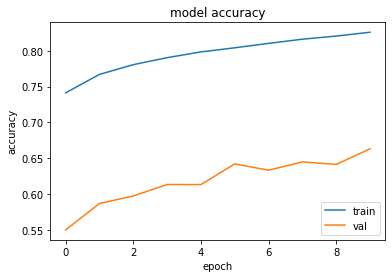

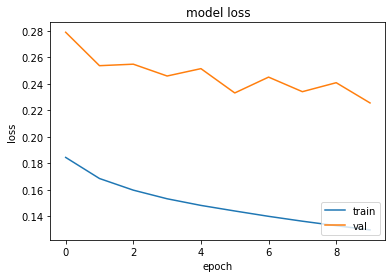

In [55]:
plot_accuracy(history)
plot_loss(history)

#### Save model

In [45]:
save_model(model, sentence_embedding_type, merge_type)

INFO:tensorflow:Assets written to: models/model_SE1_MT1_07_12_2021_11:40:04/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT1_07_12_2021_11:40:04/assets


#### Prediction
Calcualte the predictions for the test set

In [22]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

#### Evaluation

##### Multi-input classification evaluation

              precision    recall  f1-score   support

           0       0.82      0.32      0.46      3583
           1       0.58      0.93      0.71      3606

    accuracy                           0.63      7189
   macro avg       0.70      0.63      0.59      7189
weighted avg       0.70      0.63      0.59      7189

0.6265127277785506


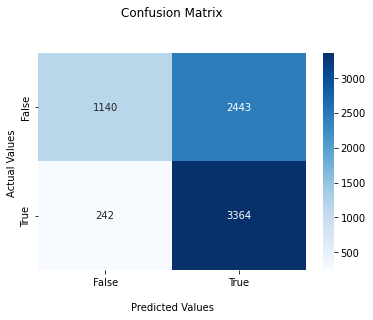

In [56]:
evaluation(predictions)

#### Claim verification evaluation

              precision    recall  f1-score   support

           0       0.81      0.32      0.46      3583
           1       0.58      0.93      0.71      3606

    accuracy                           0.63      7189
   macro avg       0.70      0.62      0.59      7189
weighted avg       0.70      0.63      0.59      7189

0.6251217137293087


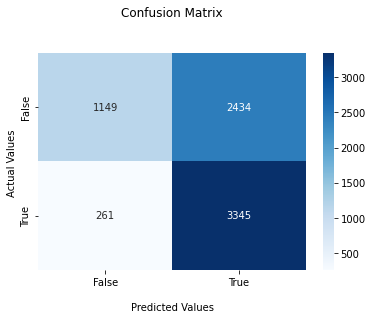

In [53]:
claims_dict = make_claims_dict()
majority_predictions = majority_pred(predictions)
evaluation(majority_predictions)

### Model using sentence embedding 1 and sum merging
Sentence embedding 1 = Encode token sequences via a RNN and take the last state as the sentence embedding

#### Create model

In [65]:
# Change vaiables in order to change sentence_embedding_type and merge_type
sentence_embedding_type = 1
merge_type = 2

In [66]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_15[0][0]']               
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_16[0][0]']         

##### Train model

In [67]:
BATCH_SIZE = 256
EPOCHS = 10

In [68]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
476/476 [==============================] - 108s 215ms/step - loss: 0.1844 - acc: 0.7416 - val_loss: 0.2744 - val_acc: 0.5514
Epoch 2/10
476/476 [==============================] - 110s 231ms/step - loss: 0.1688 - acc: 0.7663 - val_loss: 0.2740 - val_acc: 0.5668
Epoch 3/10
476/476 [==============================] - 89s 187ms/step - loss: 0.1611 - acc: 0.7789 - val_loss: 0.2587 - val_acc: 0.5954
Epoch 4/10
476/476 [==============================] - 103s 217ms/step - loss: 0.1555 - acc: 0.7871 - val_loss: 0.2451 - val_acc: 0.6165
Epoch 5/10
476/476 [==============================] - 81s 171ms/step - loss: 0.1513 - acc: 0.7930 - val_loss: 0.2531 - val_acc: 0.6162
Epoch 6/10
476/476 [==============================] - 80s 167ms/step - loss: 0.1474 - acc: 0.7990 - val_loss: 0.2427 - val_acc: 0.6286
Epoch 7/10
476/476 [==============================] - 96s 201ms/step - loss: 0.1436 - acc: 0.8046 - val_loss: 0.2395 - val_acc: 0.6384
Epoch 8/10
476/476 [==============================] 

#### Plot accuracy and loss

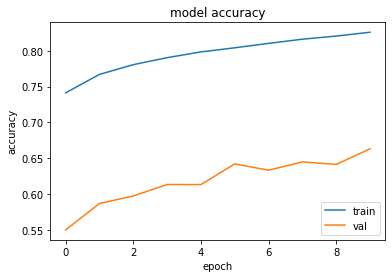

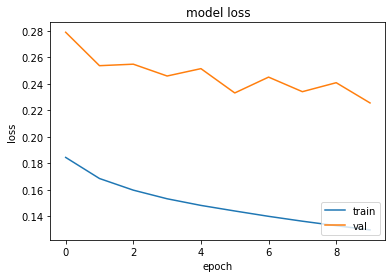

In [ ]:
plot_accuracy(history)
plot_loss(history)

#### Save model

In [ ]:
save_model(model, sentence_embedding_type, merge_type)

INFO:tensorflow:Assets written to: models/model_SE1_MT1_07_12_2021_11:40:04/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT1_07_12_2021_11:40:04/assets


#### Prediction
Calcualte the predictions for the test set

In [ ]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

#### Evaluation

##### Multi-input classification evaluation

              precision    recall  f1-score   support

           0       0.82      0.32      0.46      3583
           1       0.58      0.93      0.71      3606

    accuracy                           0.63      7189
   macro avg       0.70      0.63      0.59      7189
weighted avg       0.70      0.63      0.59      7189

0.6265127277785506


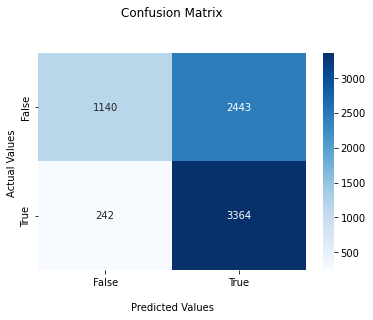

In [ ]:
evaluation(predictions)

#### Claim verification evaluation

              precision    recall  f1-score   support

           0       0.81      0.32      0.46      3583
           1       0.58      0.93      0.71      3606

    accuracy                           0.63      7189
   macro avg       0.70      0.62      0.59      7189
weighted avg       0.70      0.63      0.59      7189

0.6251217137293087


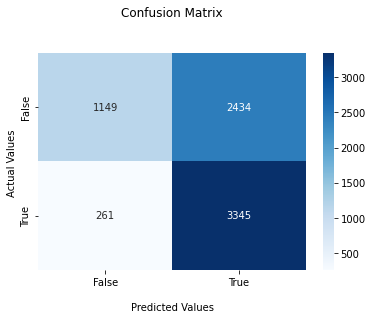

In [ ]:
claims_dict = make_claims_dict()
majority_predictions = majority_pred(predictions)
evaluation(majority_predictions)

### Model using sentence embedding 1 and mean merging
Sentence embedding 1 = Encode token sequences via a RNN and take the last state as the sentence embedding

#### Create model

In [70]:
# Change vaiables in order to change sentence_embedding_type and merge_type
sentence_embedding_type = 1
merge_type = 3

In [71]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_17[0][0]']               
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_18[0][0]']         

##### Train model

In [72]:
BATCH_SIZE = 256
EPOCHS = 10

In [73]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
476/476 [==============================] - 84s 171ms/step - loss: 0.1847 - acc: 0.7422 - val_loss: 0.2794 - val_acc: 0.5436
Epoch 2/10
476/476 [==============================] - 79s 167ms/step - loss: 0.1691 - acc: 0.7663 - val_loss: 0.2569 - val_acc: 0.5869
Epoch 3/10
476/476 [==============================] - 79s 166ms/step - loss: 0.1608 - acc: 0.7800 - val_loss: 0.2555 - val_acc: 0.5964
Epoch 4/10
476/476 [==============================] - 83s 173ms/step - loss: 0.1546 - acc: 0.7887 - val_loss: 0.2496 - val_acc: 0.6103
Epoch 5/10
476/476 [==============================] - 92s 194ms/step - loss: 0.1498 - acc: 0.7951 - val_loss: 0.2458 - val_acc: 0.6193
Epoch 6/10
476/476 [==============================] - 85s 179ms/step - loss: 0.1454 - acc: 0.8025 - val_loss: 0.2300 - val_acc: 0.6434
Epoch 7/10
476/476 [==============================] - 87s 183ms/step - loss: 0.1419 - acc: 0.8078 - val_loss: 0.2394 - val_acc: 0.6392
Epoch 8/10
476/476 [==============================] - 8

#### Plot accuracy and loss

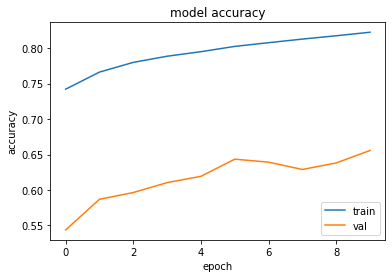

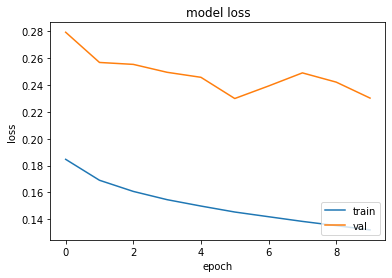

In [74]:
plot_accuracy(history)
plot_loss(history)

#### Save model

In [75]:
save_model(model, sentence_embedding_type, merge_type)

INFO:tensorflow:Assets written to: models/model_SE1_MT3_07_12_2021_12:32:31/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT3_07_12_2021_12:32:31/assets
/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### Prediction
Calcualte the predictions for the test set

In [76]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

#### Evaluation

##### Multi-input classification evaluation

              precision    recall  f1-score   support

           0       0.80      0.38      0.51      3583
           1       0.59      0.90      0.72      3606

    accuracy                           0.64      7189
   macro avg       0.70      0.64      0.62      7189
weighted avg       0.70      0.64      0.62      7189

0.6426484907497566


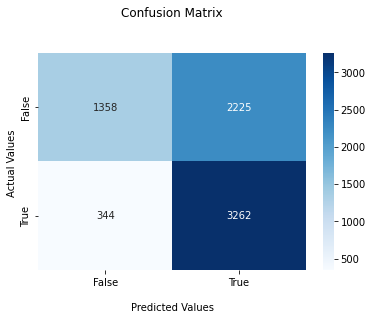

In [77]:
evaluation(predictions)

#### Claim verification evaluation

              precision    recall  f1-score   support

           0       0.79      0.38      0.52      3583
           1       0.60      0.90      0.72      3606

    accuracy                           0.64      7189
   macro avg       0.69      0.64      0.62      7189
weighted avg       0.69      0.64      0.62      7189

0.6432048963694533


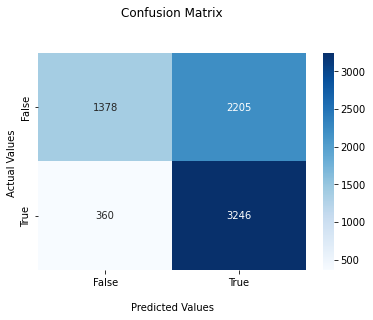

In [78]:
claims_dict = make_claims_dict()
majority_predictions = majority_pred(predictions)
evaluation(majority_predictions)